In [1]:
import numpy as np 
import random as rn
import matplotlib.pyplot as plt
import copy 

In [130]:
N=20  # numero de lipidos 
L=20 #lattice side 
#Oil and water 
O=1
W=0
#lipid
H=4 # Head 
T=3 # Tail 
por_N = ((N*6)*100)/(L*L)
print(por_N)

30.0


In [131]:
def pos(i, L):
    if i>=L:
        return i-L
    if i < 0:
        return i+L
    return i 
# find neightbors 
def vecinos(lattice,i,j,L):
    #devuelve una lista con el valor de los vecinos de esa posicion
    #comienza con la esquina superior izquierda y va bajando, como cuando uno lee
    veci=[lattice[pos(i-1,L)][pos(j-1,L)],lattice[pos(i-1,L)][pos(j,L)],lattice[pos(i-1,L)][pos(j+1,L)],
         lattice[pos(i,L)][pos(j-1,L)],lattice[pos(i,L)][pos(j+1,L)],
         lattice[pos(i+1,L)][pos(j-1,L)],lattice[pos(i+1,L)][pos(j,L)],lattice[pos(i+1,L)][pos(j+1,L)]]
    return veci

#find position of the neightbors 
def posveci(L):
    vecindad = np.zeros([L,L], dtype=list)
    for i in range(L):
        for j in range(L):
            veci=[(pos(i-1,L),pos(j-1,L)),(pos(i-1,L),pos(j,L)),(pos(i-1,L),pos(j+1,L)),
             (pos(i,L),pos(j-1,L)),(pos(i,L),pos(j+1,L)),
             (pos(i+1,L),pos(j-1,L)),(pos(i+1,L),pos(j,L)),(pos(i+1,L),pos(j+1,L))]
            vecindad[i][j]= veci
    return vecindad

In [132]:
neigh = posveci(L)
print(len(neigh))
#This is a list with the positions of the neightbors to determin position 

20


In [133]:
def add2lattice(x0, y0, value, lattice):
    """Adds a new element of type value close to the given position.
    
    Arguments:
    -x0, y0: Float, original position
    -value: Type of thing to add
    
    Return:
    Tuple containing: Boolean value indicating if it was able to allocate the value and the coordinates of the added value"""
    i = 0
    while i < 8 and lattice[neigh[x0][y0][i]] != 0 : 
        i +=1 
   
    
    if i < 8 :
        x, y = neigh[x0][y0][i]
        lattice[x, y] = value
        return (True, x, y)
    else:
        return (False, -1, -1)

In [134]:
class lipid: 
    # to put the lipids in the lattice 
    def ubicate(self , lattice):
        failed = True # I don't know 
        self.nodes = [] # Is the lipis itself keep the tail and the heads 
        while failed:
            failed = False

            if len(self.nodes) > 0: # si el tamaño de la lista es mayor a cero para la posicion x, y coloca un cero y quita el lipido 
                for x,y in self.nodes:
                    lattice[x,y] = 0
                self.nodes.clear() 

            # Get initial position of a head
            x=np.random.randint(0,L)
            y=np.random.randint(0,L)
            while lattice[x,y] != 0:
                x=np.random.randint(0,L)
                y=np.random.randint(0,L)

            lattice[x, y] = H # actualizacion de la lattice 
            self.nodes.append((x, y)) # actualizacion de la lista del lipido 

            for i in range(1, self.N_heads): # como ya esta ocupado por la primera cabeza se hacel el bucle asi 
                completed, x, y = add2lattice(x, y, H, lattice)
                if not completed:
                    failed = True
                    break
                else:
                    self.nodes.append((x, y))

            if not failed:
                for i in range(self.N_heads, self.N):
                    completed, x, y = add2lattice(x, y, T, lattice)
                    #completed: que pudo colocar el numero de cabezas 
                    if not completed:
                        failed = True
                        break
                    else:
                        self.nodes.append((x, y))
    def __init__(self, lattice, N_heads, N_tails): 
        self.N_heads = N_heads 
        self.N_tails = N_tails 
        self.N = N_heads + N_tails
        self.nodes = []
        self.ubicate(lattice)
    
    def twist(self, lattice):
        n = np.random.randint(0,self.N) #elige un numero aleatorio entre el total del lipido 
        positions = [] # 
        for i in range(8):
            if lattice[neigh[self.nodes[n]][i]] == 0:
                if n == 0 or neigh[self.nodes[n]][i] in neigh[self.nodes[n-1]] : 
                    if n == self.N - 1 or neigh[self.nodes[n]][i] in neigh[self.nodes[n+1]]:
                        positions.append(neigh[self.nodes[n]][i])
        if positions:
            new_pos = np.random.randint(0,len(positions))
            lattice[positions[new_pos]] = lattice[self.nodes[n]]
            lattice[self.nodes[n]] = 0
            self.nodes[n] = positions[new_pos]
            return True
        
        return False
    
    def reptate_forward(self, lattice):
        positions = []
        for i in range(8): 
            if lattice[neigh[self.nodes[0]][i]] == 0:
                positions.append(neigh[self.nodes[0]][i])
        if positions:
            new_pos = np.random.randint(0,len(positions))
            lattice[positions[new_pos]] = lattice[self.nodes[0]]
            for i in range(1,self.N):
                lattice[self.nodes[i-1]] = lattice[self.nodes[i]]
            lattice[self.nodes[-1]] = 0 
            for i in range(self.N - 2, -1, -1): 
                self.nodes[i+1] = self.nodes[i]
            self.nodes[0] = positions[new_pos]
            return True 
        
        return False
    
    def reptate_backward(self, lattice):
        positions = []
        for i in range(8): 
            if lattice[neigh[self.nodes[-1]][i]] == 0:
                positions.append(neigh[self.nodes[-1]][i])
        if positions:
            new_pos = np.random.randint(0,len(positions))
            lattice[positions[new_pos]] = lattice[self.nodes[-1]]
            for i in range(self.N-1, 0, -1):
                lattice[self.nodes[i]] = lattice[self.nodes[i-1]]
            lattice[self.nodes[0]] = 0 
            for i in range(0, self.N - 1): 
                self.nodes[i] = self.nodes[i+1]
            self.nodes[-1] = positions[new_pos]
            return True 
        
        return False
            

In [135]:
Ell = -1
Ehh = -1
Ehl = 1
W = Ehl - 0.5*Ehh - 0.5*Ell 
w = 0.1538
B = w/W
def get_energy(lattice):
    energy=0
    for i in range(L):
        for j in range(L):
            veci=neigh[i,j]
            for pos_veci in veci:
                if lattice[pos_veci] == lattice[i][j]:
                    if lattice[i][j] == T:
                        energy += Ell
                    else: 
                        energy += Ehh
                else: 
                    if lattice[i][j] == H or lattice[pos_veci] == H:
                        if lattice[i][j] == W or lattice[pos_veci] == W:
                            energy += Ehh
                        else:
                            energy += Ehl
                    else:
                        energy += Ehl 
                 
    return energy/2

In [136]:
def metropolis():
    #L = 40
    #N = 90
    lipidos = N*[None]
    lattice = np.zeros([L,L])
    Energia = []
    lattice_graph = []
    for i in range(N):
        lipidos[i] = lipid(lattice,2,4)
    energy = get_energy(lattice)
    for i in range(5000):
        Energia.append(energy)
        new_lattice = lattice.copy()
        working = False 
        while not working: 
            ind_lipid = np.random.randint(0,N)
            chosen_lipid = copy.deepcopy(lipidos[ind_lipid])
            if np.random.random() < 0.5:
                working = chosen_lipid.twist(new_lattice)
            else:
                if np.random.random() < 0.5: 
                    working = chosen_lipid.reptate_forward(new_lattice)
                else: 
                    working = chosen_lipid.reptate_backward(new_lattice)
        new_energy = get_energy(new_lattice) 
        change_energy = new_energy-energy 
        if change_energy < 0: 
            lattice = new_lattice
            energy = new_energy
            lipidos[ind_lipid] = chosen_lipid
        else: 
            if np.random.random() < np.exp(-B*change_energy):
                lattice = new_lattice
                energy = new_energy
                lipidos[ind_lipid] = chosen_lipid
        if i >= 2000 and i%500 == 0: 
            lattice_graph.append(lattice)
    lattice_graph.append(lattice)
    return Energia, lattice_graph

In [137]:
En, lattice = metropolis()

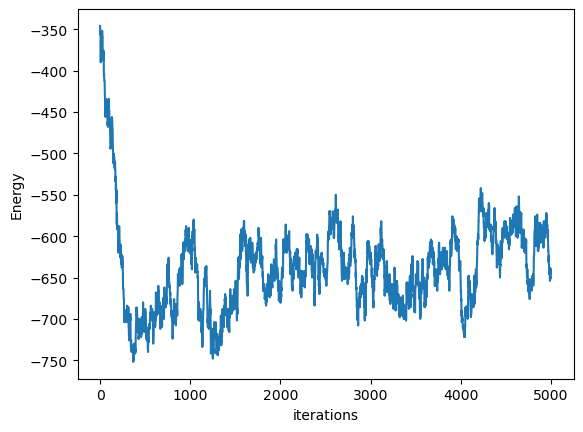

In [138]:
plt.plot(En)
plt.xlabel("iterations")
plt.ylabel("Energy")
#plt.savefig("Energy20x20_c80.pdf")
plt.show()

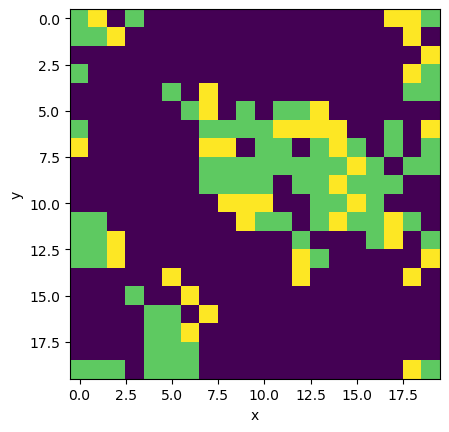

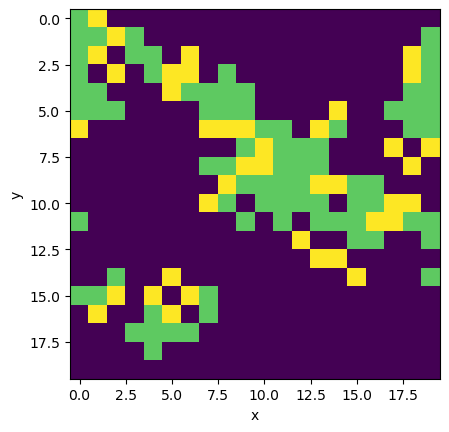

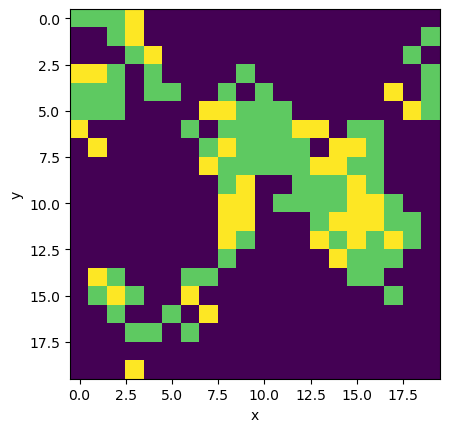

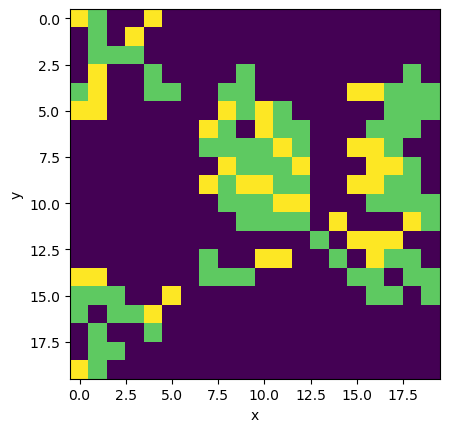

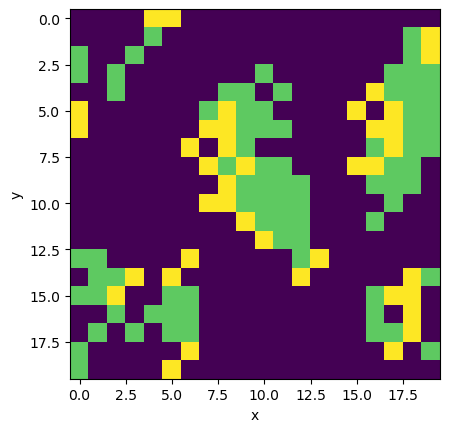

In [139]:
for i in range(2,len(lattice)):
    plt.imshow(lattice[i])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.savefig(f"{L}x{L}_l{N}_i{i}_{por_N}_caso2.pdf")
    plt.show()
    